[10.0, 0.06666666666666667]
[4.0, 0.07142857142857142]
[2.5, 0.07142857142857142]
[0.4, 0.07142857142857142]
[1.0, 0.07142857142857142]
[1.0, 0.07142857142857142]
[15.0, 0.07692307692307693]
[1.0, 0.07692307692307693]
[3.0, 0.07692307692307693]
[100.0, 0.07692307692307693]
[4.0, 0.07692307692307693]
[5.0, 0.08333333333333333]
[20.0, 0.09090909090909091]
[1.0, 0.09090909090909091]
[2.0, 0.09090909090909091]
[2.5, 0.09090909090909091]
[1.5, 0.09090909090909091]
[2.0, 0.09090909090909091]
[24.0, 0.09090909090909091]
[1.5, 0.09090909090909091]
[2.5, 0.1]
[5.0, 0.1111111111111111]
[5.0, 0.1111111111111111]
[5.0, 0.1111111111111111]
[2.5, 0.1111111111111111]
[0.5, 0.1111111111111111]
[2.5, 0.1111111111111111]
[3.0, 0.1111111111111111]
[14.0, 0.1111111111111111]
[5.0, 0.1111111111111111]
[5.0, 0.1111111111111111]
[5.0, 0.1111111111111111]
[2.5, 0.1111111111111111]
[2.5, 0.1111111111111111]
[1.0, 0.1111111111111111]
[3.5, 0.1111111111111111]
[1.0, 0.1111111111111111]
[2.5, 0.1111111111111111]


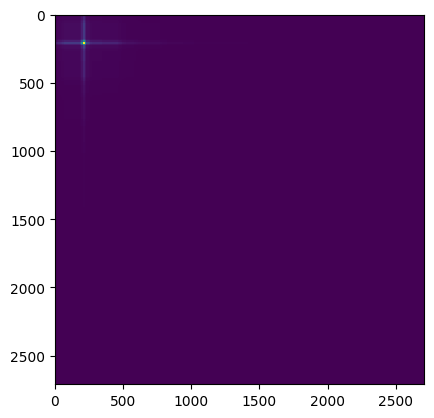

In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

"""

EXAMPLE DATA:

scholarship_data = {
    'Scholarship_A': [0.05, 0.1],  <- [Expected Return, Risk]
    'Scholarship_B': [0.07, 0.08],
    'Scholarship_C': [0.06, 0.12]
}

"""

#parse scholarship data

def parse_scholarships(filename):
    scholarships = {}
    with open(filename, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 16):
            try:
                name = lines[i + 2].strip()
                amount = lines[i + 7].strip().replace('<label>Amount:</label>', '')
                due_date = lines[i + 11].strip().replace('<label>Due Date:</label>', '')
                if amount.lower() == "varies" or due_date.lower() == "varies":
                    pass
                else:
                    scholarships[name] = [due_date, amount]
            except:
                pass
    return scholarships

def get_days_difference(date1_str, date2_str):

    date1 = datetime.strptime(date1_str, "%B %d, %Y")
    date2 = datetime.strptime(date2_str, "%B %d, %Y")
    
    difference = abs((date1 - date2).days)

    #return difference in days between 2 dates
    
    return difference

filename = "scholarships.txt"
scholarships = parse_scholarships(filename)

current_date = datetime.now()

formatted_date = current_date.strftime("%B %d, %Y")

scholarship_data = {}

for name, info in scholarships.items():

    due_date, amount = info

    date_difference = get_days_difference(formatted_date, due_date)

    stripped_amount = int(amount.replace("$", "").replace(",", ""))

    #set return relative to scholarship amount
    
    expected_return = stripped_amount / 1000  # Assuming a $1000 scholarship as a reference

    if date_difference > 0:

        #set risk relative to number of days before the application due date

        expected_risk = 1 / date_difference
    
        scholarship_data[name] = [expected_return,expected_risk]
    
    else:

        #skip scholarship applications with passed due dates

        pass
    
test_values = list(scholarship_data.values())
    
for i in range(100):
    print(test_values[i])

# Extract expected returns and covariance matrix
mu = np.array([data[0] for data in scholarship_data.values()])
sigma_values = np.array([data[1] for data in scholarship_data.values()])
sigma = np.outer(sigma_values, sigma_values)


# Plot covariance matrix
plt.imshow(sigma, interpolation="nearest")
plt.show()


# Set risk factor and budget
q = 0.5  # risk factor
budget = len(scholarship_data) // 2  # budget

# Set up portfolio optimization problem
portfolio = PortfolioOptimization(
    expected_returns=mu,
    covariances=sigma,
    risk_factor=q,
    budget=budget
)

# Convert portfolio optimization problem to quadratic program
qp = portfolio.to_quadratic_program()

# Define a function to print optimization results
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal selection: {}, Portfolio value: {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("Selection\tPortfolio Value\tProbability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%s\t\t%.4f\t\t%.4f" % (x, value, v))

In [ ]:
# Set random seed for reproducibility
np.random.seed(1234)

# Set optimizer parameters
cobyla = COBYLA()
cobyla.set_options(maxiter=500)

print("Optimization Parameters Set")

In [ ]:
# VQE optimization
ry = TwoLocal(len(scholarship_data), "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result_vqe = svqe.solve(qp)
print("\nVQE Results:")
print_result(result_vqe)

In [18]:
# QAOA optimization
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_qaoa = qaoa.solve(qp)
print("\nQAOA Results:")
print_result(result_qaoa)


QAOA Results:
Optimal selection: [0. 1. 0. 0. 1.], Portfolio value: -113.0000

----------------- Full result ---------------------
Selection	Portfolio Value	Probability
---------------------------------------------------
[1 1 0 0 0]		-23.0000		0.1240
[0 1 0 1 0]		-16.0000		0.1133
[0 1 0 0 1]		-113.0000		0.1025
[0 0 1 0 1]		-99.0000		0.0703
[0 0 0 1 1]		-101.0000		0.0527
[0 1 0 0 0]		-14.5000		0.0479
[1 0 0 1 1]		-108.5000		0.0479
[0 0 1 1 1]		-99.5000		0.0430
[0 1 1 0 1]		-111.5000		0.0410
[1 1 0 0 1]		-120.5000		0.0391
[0 1 1 0 0]		-14.0000		0.0371
[0 0 1 1 0]		-2.0000		0.0361
[1 0 1 1 1]		-106.0000		0.0273
[1 0 0 1 0]		-11.0000		0.0254
[1 0 0 0 0]		-9.5000		0.0234
[1 1 0 1 0]		-23.5000		0.0225
[1 0 0 0 1]		-108.0000		0.0186
[1 0 1 0 0]		-9.0000		0.0176
[0 1 1 1 0]		-14.5000		0.0156
[0 0 0 1 0]		-2.5000		0.0146
[0 0 1 0 0]		-0.5000		0.0117
[0 1 0 1 1]		-113.5000		0.0098
[1 0 1 0 1]		-106.5000		0.0098
[1 0 1 1 0]		-9.5000		0.0098
[1 1 1 0 1]		-118.0000		0.0088
[0 1 1 1 1]		-111.0000		